## Research Spring2022 Final
Peter Jin

May 12 2022

In [1]:
## at the end try putting on github and pulling and running

import numpy as np
import xarray as xr
import pandas as pd
import glob
import cartopy.crs as ccrs

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

#### 1. Make a list of all track (tcp) and forecast (nc) files. (hint glob is your friend)

- a. How many track files are there for 2021? For 2022? (5pts)
- b. How many forecast files are there for 2021? For 2022? (5pts)
- c. How many unique storm names? In 2021? (5pts)
- d. How many unique storm names without “invest”? In 2021? (5pts)

In [2]:
direc = '/data2/qy2216/HWRF_wind/'
filesTpc = glob.glob(direc+'/*/*/track/*.tpc')
filesNc = glob.glob(direc+'/*/*/nc/*.nc')

filesTpc2021 = glob.glob(direc+'/hwrf.2021*/*/track/*.tpc')
filesTpc2022 = glob.glob(direc+'/hwrf.2022*/*/track/*.tpc')
filesNc2021 = glob.glob(direc+'/hwrf.2021*/*/nc/*.nc')
filesNc2022 = glob.glob(direc+'/hwrf.2022*/*/nc/*.nc')

print('a. 2021:',len(filesTpc2021),'\n   2022:',len(filesTpc2022))
print('b. 2021:',len(filesNc2021),'\n   2022:',len(filesNc2022))
##################################
stormSet = set([])
for i in filesTpc:
    stormSet.add(i.split('/')[7].split('.')[0])
stormSet2021 = set([])
for i in filesTpc2021:
    stormSet2021.add(i.split('/')[7].split('.')[0])
    
print('c. Total:',len(stormSet),'\n   2021:',len(stormSet2021))
##################################
stormSetWOInvest = set([])
for i in stormSet:
    if 'INVEST' not in i:
        stormSetWOInvest.add(i)
        
stormSetWOInvest2021 = set([])
for i in stormSet2021:
    if 'INVEST' not in i:
        stormSetWOInvest2021.add(i)
        
print('d. Total:',len(stormSetWOInvest),'\n   2021:',len(stormSetWOInvest2021))
#print(stormSetWOInvest2021)
#extra: find what last letter means, maybe plot names of storms on lat-lon (last letter corresponds to area)
#small issue -- e.g. TEN10W grows into CEMPAKA10W -> not actually unique?

a. 2021: 2026 
   2022: 751
b. 2021: 86685 
   2022: 32182
c. Total: 223 
   2021: 169
d. Total: 164 
   2021: 125


---
#### 2. Read the file /data2/qy2216/HWRF_wind/hwrf.2021060212/invest93s/track/INVEST93S.2021060212.stats.tpc
- a. Plot the track (lat-lon grid). Indicate the central pressure (MIN PRESS (hPa)) by
color along the track. (10pts) (dots at lat-lon locations w/ colors)
- b. Make a scatter plot of central pressure vs. wind speed (MAX SFC WIND (KTS)).
(10pts)

##### a. Plot the track (lat-lon grid). Indicate the central pressure (MIN PRESS (hPa)) by color along the track. (10pts) (dots at lat-lon locations w/ colors)

In [3]:
tpcPath2 = '/data2/qy2216/HWRF_wind/hwrf.2021060212/invest93s/track/INVEST93S.2021060212.stats.tpc'

In [4]:
def readTPC(tpc):
    colspecs = [(5, 10), (18, 25), (32, 38), (56, 63), (89, 95)]
    df = pd.read_fwf(tpc, colspecs=colspecs, header=None, skiprows=12, names=['hour', 'lon', 'lat', 'P', 'V'])
    if(df['hour'].empty or df['lat'].empty or df['lon'].empty or df['P'].empty or df['V'].empty):
        df = 0
    else:
        df = df[:df.loc[df['hour'] == 'ORECA'].index[0]] #find where the df ends (based on "FORECAST" which is written directly after the last line of each .tpc df)
        df['hour'] = df['hour'].astype(float)
        df['lat'] = df['lat'].astype(float)
        df['lon'] = df['lon'].astype(float)
        df['P'] = df['P'].astype(float)
        df['V'] = df['V'].astype(float)
    return df

In [5]:
def plotTracks_P(tpcFiles):
    plt.figure()
    for i in tpcFiles:
        dfi = readTPC(i)
        if(dfi is not 0): 
            plt.scatter(dfi['lon'], dfi['lat'], s=10, c=dfi['P'], cmap='viridis', label=i.split('/')[7].split('.')[1])
            plt.plot(dfi['lon'],dfi['lat'])
    plt.colorbar()

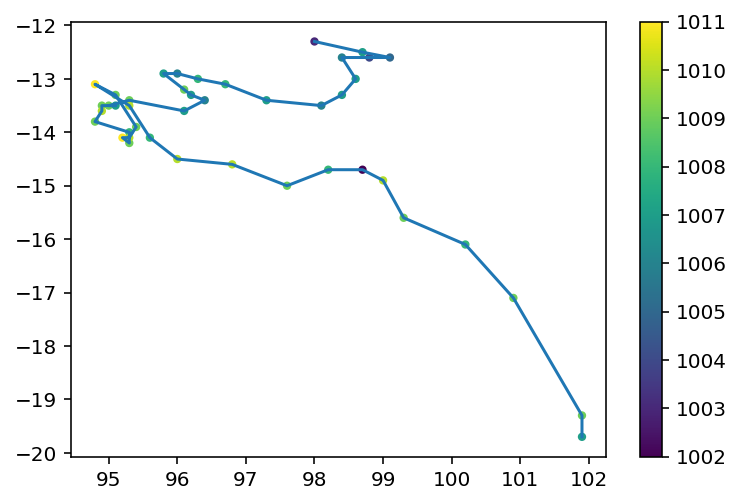

In [6]:
plotTracks_P([tpcPath2]) 
plt.show()

##### b. Make a scatter plot of central pressure vs. wind speed (MAX SFC WIND (KTS)).

In [7]:
def plotPvsV(tpcFiles):
    plt.figure()
    for i in tpcFiles:
        dfi = readTPC(i)
        if(dfi is not 0): 
            plt.scatter(dfi['V'], dfi['P'], label=i.split('/')[7].split('.')[1])

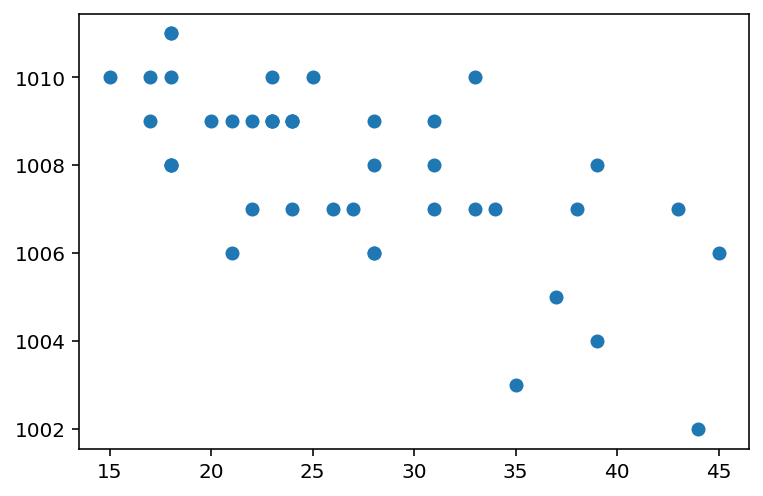

In [8]:
plotPvsV([tpcPath2])
plt.show()

---
#### 3. Read all the track files for the storm batsirai08s
- a. Plot all the tracks on a map with coastlines. (10pts)
    - i. First w/o coastlines
    - ii. Cartopy for coastlines (ask for example)
- b. Plot central pressure as a function of forecast target date (forecast target date = start date + lead time in hours). (10pts)
- c. Extra credit: find the observed central pressure and add it to your plot. Ibtracs, jtwc

##### a. Plot all the tracks on a map with coastlines. (10pts)
    i. First w/o coastlines

In [9]:
def plotTracks(tpcFiles):
    plt.figure()
    #crossGlobe = False
    for i in tpcFiles:
        
        dfi = readTPC(i)
        if(dfi is not 0):
            #print(dfi['lon'])
            plt.scatter(dfi['lon'], dfi['lat'], s=5, label=i.split('/')[7].split('.')[1])
            masked_lon = dfi['lon']
            masked_lat = dfi['lat']
            
            for j in range(len(dfi['lon'])-1):
                if abs(dfi['lon'][j]-dfi['lon'][j+1])>300:
                    masked_lon = np.ma.masked_where(dfi['lon'][j], dfi['lon'])
                    masked_lon = np.ma.masked_where(dfi['lon'][j+1], dfi['lon'])
                    masked_lat = np.ma.masked_where(dfi['lat'][j], dfi['lat'])
                    masked_lat = np.ma.masked_where(dfi['lat'][j+1], dfi['lat'])

            plt.plot(masked_lon,masked_lat)
        #plt.legend()

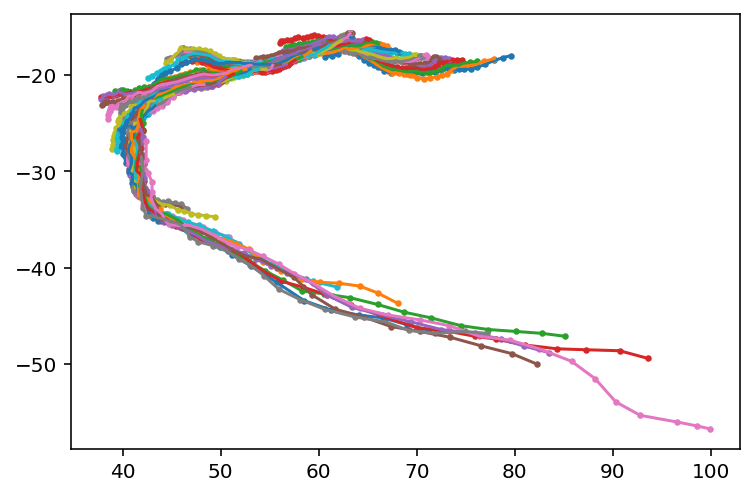

In [10]:
filesTpc_batsirai08s = glob.glob(direc+'/*/batsirai08s/track/*.tpc')
        
plotTracks(filesTpc_batsirai08s)
plt.show()

    ii. Cartopy for coastlines (ask for example)

In [11]:
#cartopy
def plotTracksCoastlines(tpcFiles):
    plt.figure()
    proj_map = ccrs.PlateCarree()
    proj_data = ccrs.PlateCarree() 
    ax = plt.subplot(projection = proj_map)
    ax.coastlines()
    for i in tpcFiles:    
        dfi = readTPC(i)
        if(dfi is not 0):
            plt.scatter(dfi['lon'], dfi['lat'], s=5, label=i.split('/')[7].split('.')[1], transform=proj_data)
            masked_lon = dfi['lon']
            masked_lat = dfi['lat']
            
            for j in range(len(dfi['lon'])-1):
                if abs(dfi['lon'][j]-dfi['lon'][j+1])>300:
                    masked_lon = np.ma.masked_where(dfi['lon'][j], dfi['lon'])
                    masked_lon = np.ma.masked_where(dfi['lon'][j+1], dfi['lon'])
                    masked_lat = np.ma.masked_where(dfi['lat'][j], dfi['lat'])
                    masked_lat = np.ma.masked_where(dfi['lat'][j+1], dfi['lat'])

            plt.plot(masked_lon,masked_lat,transform=proj_data)

    gridlines = ax.gridlines(draw_labels=True)

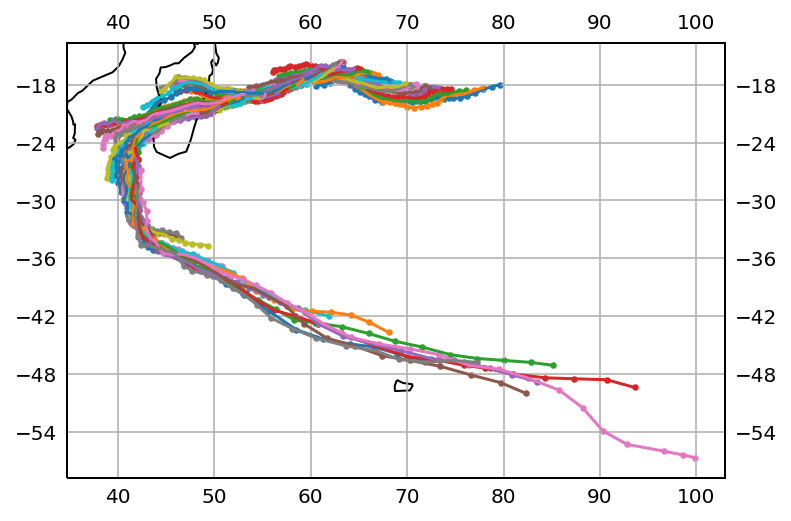

In [12]:
plotTracksCoastlines(filesTpc_batsirai08s)
plt.show()    

##### b. Plot central pressure as a function of forecast target date (forecast target date = start date + lead time in hours). (10pts)

In [13]:
def plotPvsTarget(tpcFiles):
    plt.figure(figsize=(15,3))
    for i in tpcFiles:
        dfi = readTPC(i)
        if(dfi is not 0):
            startTimei = pd.to_datetime(i.split('/')[7].split('.')[1], format='%Y%m%d%H')
            forecastTimes = [(startTimei+pd.DateOffset(hours=x*3)) for x in range(len(dfi.hour))]
            plt.plot(forecastTimes,dfi['P'])
                       
#/data2/clee/bttracks/IBTrACS.ALL.v04r00.nc

In [14]:
# WORK IN PROGRESS
def plotPvsTargetCM(tpcFiles):
    plt.figure(figsize=(15,3))
    
    for i in tpcFiles:
        dfi = readTPC(i)
        if(dfi is not 0):
            startTimei = pd.to_datetime(i.split('/')[7].split('.')[1], format='%Y%m%d%H')
            forecastTimes = [(startTimei+pd.DateOffset(hours=x*3)) for x in range(len(dfi.hour))]
            
            plt.pcolormesh(forecastTimes,startTimei,dfi['P'])

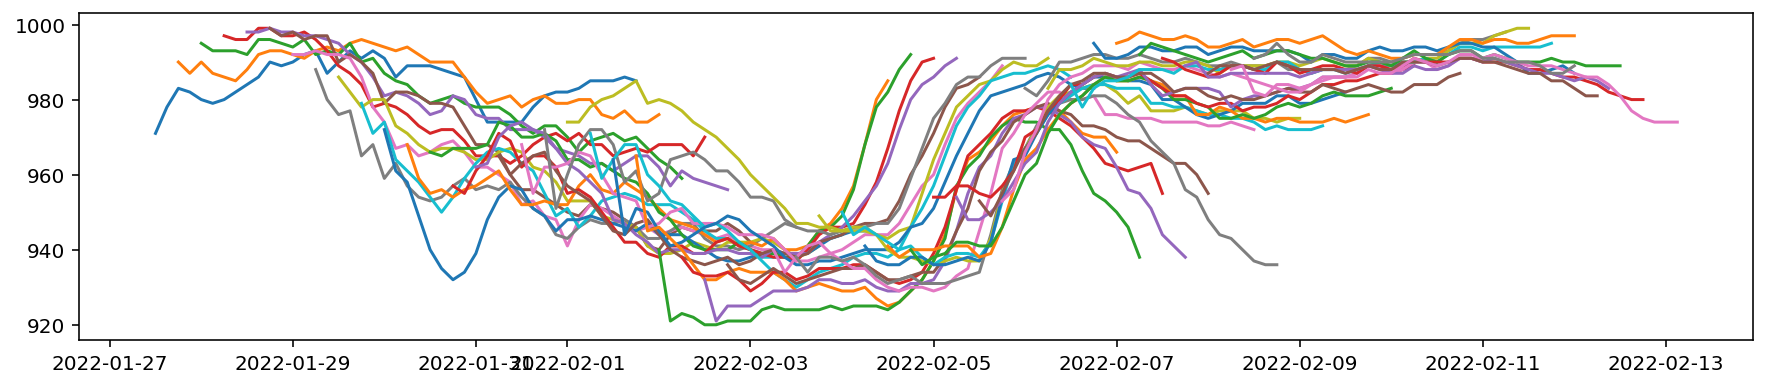

In [15]:
plotPvsTarget(filesTpc_batsirai08s)
#plotPvsTargetCM(filesTpc_batsirai08s)
plt.show()

---
#### 4. Read all the track files
- a. Plot all the tracks on a (global) map with coastlines. (10pts)
    - i. First w/o coastlines
    - ii. Cartopy for coastlines (ask for example)
- b. Make a scatter plot of all central pressure vs. wind speed values. (10pts)
- c. Extra credit: fit line to the scatter plot in (b)
- d. Extra credit: Make a map of track density (number of tracks per 1x1 degree box).

##### a. Plot all the tracks on a (global) map with coastlines. (10pts)
    i. First w/o coastlines
    ii. Cartopy for coastlines (ask for example)

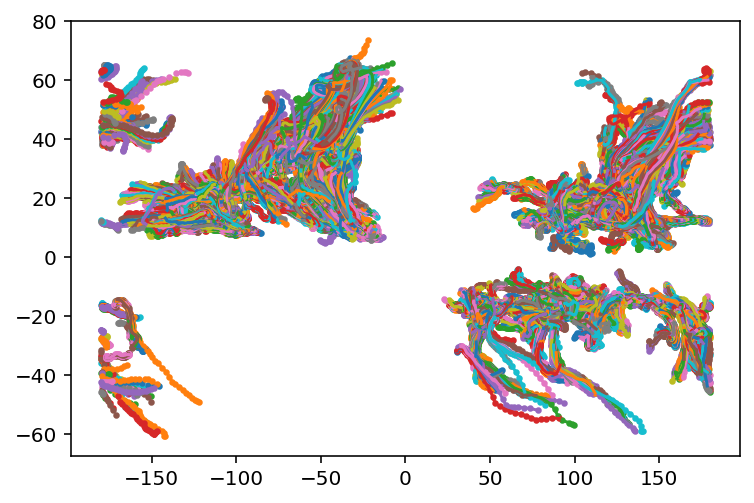

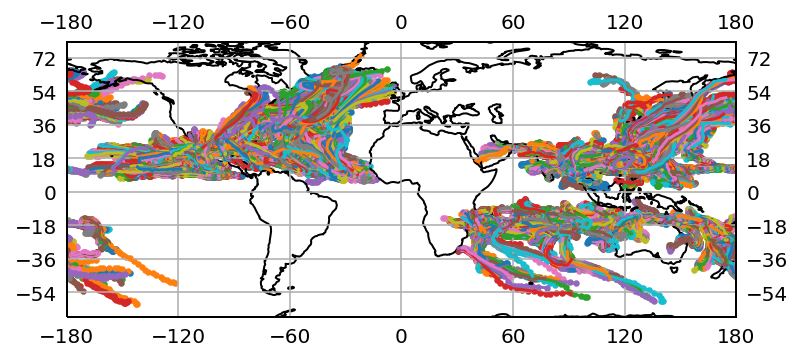

In [16]:
filesTpc_all = glob.glob(direc+'/*/*/track/*.tpc')
        
plotTracks(filesTpc_all)
plotTracksCoastlines(filesTpc_all)
plt.show()

##### b. Make a scatter plot of all central pressure vs. wind speed values. (10pts)

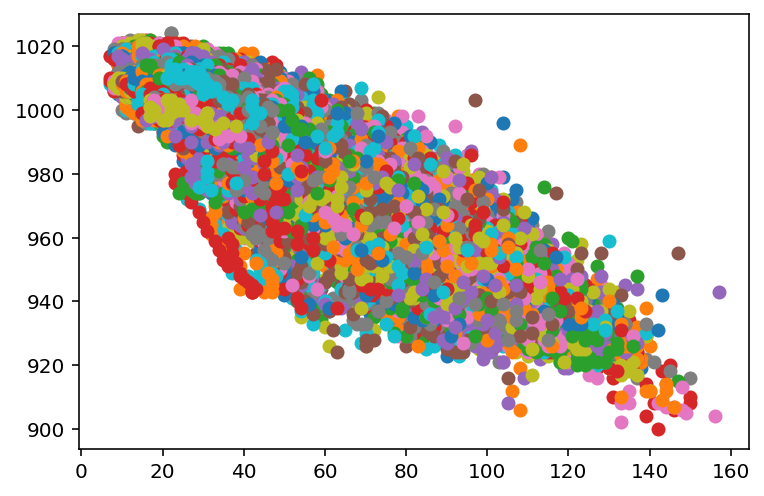

In [17]:
plotPvsV(filesTpc_all)
plt.show()

---
#### 5. Read all the forecast files for the storm batsirai08s
- a. Plot average storm-centered rainfall rate as a function of radius (10pts) (average over theta; Fig. 11!)
    - i. One curve with average of all data.
    - ii. Other curves with average conditional on wind speed.
- b. Extra credit: principal component analysis of all storm-centered rainfall snapshots
- c. Plot accumulated rainfall on lat-lon plot (10pts)

##### a. Plot average storm-centered rainfall rate as a function of radius (10pts) (average over theta; Fig. 11!)
    i. One curve with average of all data.
    ii. Other curves with average conditional on wind speed.

In [16]:
#create polar grid
ntheta_pts = 201
nr_pts = 200
rmax = 300

#FIX rmax name
r1 = np.linspace(0, rmax, nr_pts)
theta1 = np.linspace(-np.pi, np.pi, ntheta_pts)

theta2, r2 = np.meshgrid(theta1, r1)

#cartesian coordinates (in km) of the polar coordinates
polar_x2 = r2 * np.cos(theta2)
polar_y2 = r2 * np.sin(theta2)

In [17]:
#Create Interpolate Function

def makeInterpPolar(dsi, i, tpcPath, gridx = polar_x2, gridy = polar_y2):
    zi = dsi.APCP_surface.isel(time=0).values
    loni = dsi.longitude.values
    lati = dsi.latitude.values
    df = readTPC(tpcPath)
    xcenteri = df[df.hour == i].lon.values[0]
    ycenteri = df[df.hour == i].lat.values[0]
    xi1 = (loni - xcenteri)*np.cos(np.deg2rad(ycenteri))*110.567
    yi1 = (lati - ycenteri)*110.567
    xi2,yi2 = np.meshgrid(xi1,yi1)
    # number of points X 2 matrix of x y
    xyi = np.stack((xi2.flatten(), yi2.flatten())).T

    interpi = NearestNDInterpolator(xyi, zi.flatten())
    Zi = interpi(gridx, gridy)
    return Zi

In [18]:
#returns lists with indices of the hours during which the storm is a particular category
def sortIntensity(tpcPath):
    df = readTPC(tpcPath)
    intensity = df.V
    TS = []
    CAT12 = []
    CAT35 = []
    
    #can make this 1 line -- maybe where
    for i,j in enumerate(df.V[0:]):
        if (j>=18 and j<34):
            TS.append(i)
        if (j>=34 and j<49):
            CAT12.append(i)
        if (j>=49):
            CAT35.append(i)
    return TS,CAT12,CAT35

In [46]:
def findTotalCenteredPolarSorted(ncPaths,tpcPaths):
    centeredCum = 0
    centeredCumTs = 0
    centeredCumCat12 = 0
    centeredCumCat35 = 0
    #lengths of arrays
    L = 0
    tsiL = 0
    cat12iL = 0
    cat35iL = 0
    
    for tpcPath in tpcPaths:
        dfi = readTPC(tpcPath)
        if(dfi is not 0):
            tsi, cat12i, cat35i = sortIntensity(tpcPath)
            TSdata = np.zeros(len(tsi), dtype=np.ndarray)
            cat12data = np.zeros(len(cat12i), dtype=np.ndarray)
            cat35data = np.zeros(len(cat35i), dtype=np.ndarray)
            tscounter = 0 
            cat12counter = 0
            cat35counter = 0

            hourCounter = 0
            startHour = 0
            for ncPath in ncPaths:
                if (tpcPath[29:39]==ncPath[29:39]): #check if same forecast date
                    hourCounter += 3
                    ncInterest = ncPath[:-8]

            dataarray = np.zeros((hourCounter-startHour)//3, dtype=np.ndarray)
            for i,j in enumerate(range(startHour,hourCounter,3)): ## CHANGE STARTHOUR ENDHOUR STEPHOUR
                hour = '%03d' % j  
                ds = xr.open_dataset(ncInterest+'.f'+ hour+'.nc')
                print(ds)
                print(ncInterest+'.f'+ hour+'.nc')
                if(dfi.shape[0]>j):
                    dataarray[i] = makeInterpPolar(ds, j, tpcPath) 
                    if i in tsi:
                        TSdata[tscounter] = makeInterpPolar(ds, j, tpcPath) 
                        tscounter += 1
                    if i in cat12i:
                        cat12data[cat12counter] = makeInterpPolar(ds, j, tpcPath) 
                        cat12counter += 1
                    if i in cat35i:
                        cat35data[cat35counter] = makeInterpPolar(ds, j, tpcPath)
                        cat35counter += 1

            centeredCum += np.sum(dataarray, axis=0)
            centeredCumTs += np.sum(TSdata, axis=0)
            centeredCumCat12 += np.sum(cat12data, axis=0)
            centeredCumCat35 += np.sum(cat35data, axis=0)
            L += len(tsi)
            L += len(cat12i)
            L += len(cat35i)
            tsiL += len(tsi)
            cat12iL += len(cat12i)
            cat35iL += len(cat35i)
              
    return [centeredCum,L],[centeredCumTs,tsiL], [centeredCumCat12,cat12iL], [centeredCumCat35,cat35iL]

In [50]:
def plotMeanRainfallRateV(ds,ts,cat12,cat35):
    ## need to generalize here to make ds be list of ds'
    
    #CHANGE NUMDATA
    meanRainfall = np.mean(ds[0], axis=1)/ds[1]
    plt.figure()
    plt.scatter(r1,meanRainfall,s=3, label = "Cumulative")
    
    if isinstance(ts[0],np.ndarray):
        meanRainfallTs = np.mean(ts[0], axis=1)/ts[1]
        plt.scatter(r1,meanRainfallTs,s=3, label = "TS")
    if isinstance(cat12[0],np.ndarray):
        meanRainfallcat12 = np.mean(cat12[0], axis=1)/cat12[1]
        plt.scatter(r1,meanRainfallcat12,s=3, label = "CAT12")
    if isinstance(cat35[0],np.ndarray):
        meanRainfallcat35 = np.mean(cat35[0], axis=1)/cat35[1]
        plt.scatter(r1,meanRainfallcat35,s=3, label = "CAT35")
    
    plt.xlabel("Radial Distance (km)")
    plt.ylabel("Mean Rain Rate (mmh^-1)")
    plt.legend()

In [17]:
#filesTpc_batsirai08s = glob.glob(direc+'/*/batsirai08s/track/*.tpc')
filesNc_batsirai08s = glob.glob(direc+'/*/batsirai08s/nc/*.nc')

In [ ]:
centeredCum_b,Ts_b,Cat12_b,Cat35_b = findTotalCenteredPolarSorted(filesNc_batsirai08s,filesTpc_batsirai08s)

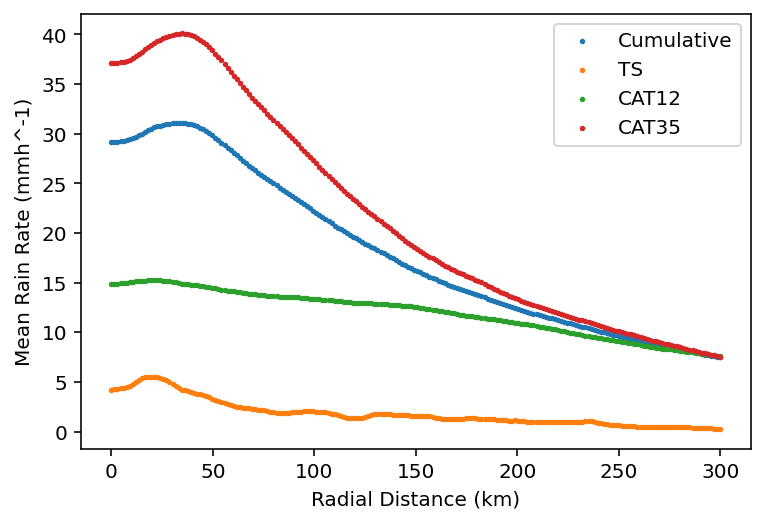

In [51]:
plotMeanRainfallRateV(centeredCum_b, Ts_b, Cat12_b, Cat35_b)
plt.show()

##### c. Plot accumulated rainfall on lat-lon plot (10pts)

In [18]:
def findCorners(ncPaths):
    minx = np.inf
    maxx = -np.inf
    miny = np.inf
    maxy = -np.inf
    for ncPath in ncPaths: 
        ds = xr.open_dataset(ncPath)
        if min(ds.longitude.values)<minx:
            minx = min(ds.longitude.values)
        if max(ds.longitude.values)>maxx:
            maxx = max(ds.longitude.values)
        if min(ds.latitude.values)<miny:
            miny = min(ds.latitude.values)
        if max(ds.latitude.values)>maxy:
            maxy = max(ds.latitude.values)
    return minx,maxx,miny,maxy

In [19]:
#create cartesian grid
nx_pts = 300
ny_pts = 300

def createCartGrid(ncPaths):
    corners = findCorners(ncPaths)
    x1 = np.linspace(corners[0], corners[1], nx_pts)
    y1 = np.linspace(corners[2], corners[3], ny_pts)

    x2, y2 = np.meshgrid(x1, y1)
    return x1,y1,x2,y2

In [20]:
def makeInterpCart(dsi, gridx, gridy):
    zi = dsi.APCP_surface.isel(time=0).values
    loni = dsi.longitude.values
    lati = dsi.latitude.values

    xi2,yi2 = np.meshgrid(loni,lati)
    # number of points X 2 matrix of x y
    xyi = np.stack((xi2.flatten(), yi2.flatten())).T

    interpi = NearestNDInterpolator(xyi, zi.flatten())
    Zi = interpi(gridx, gridy)
    return Zi

In [24]:
def findTotalMovingCenter(ncPaths):
    dataarray = np.zeros(len(ncPaths), dtype=np.ndarray)
    #for i,j in enumerate(range(startHour,endHour,stepHour)):
    counter = 0 
    for ncPath in ncPaths:
        ds = xr.open_dataset(ncPath)
        x2,y2 = createCartGrid(ncPaths)[2:]
        dataarray[counter] = makeInterpCart(ds, x2, y2)
        counter += 1
        print(counter)
        
    #find total rainfall
    cum = np.sum(dataarray, axis=0)
    return dataarray, cum

In [25]:
def plotTotalMovingCenter(ncPaths,cum):
    #Plot total rainfall
    plt.figure()
    grid = createCartGrid(ncPaths)
   
    plt.pcolormesh(grid[0], grid[1], np.log(cum), shading='gouraud')
    plt.colorbar()
    plt.title("Superimposed Centered Data: " + str(t))

In [26]:
#this takes a long time to run
cum = findTotalMovingCenter(filesNc_batsirai08s)[1]

1
2
3
4
5


KeyboardInterrupt: 

In [ ]:
plotTotalMovingCenter(filesNc_batsirai08s,cum)
plt.gca().set_aspect('equal')
plt.show()

In [27]:
print(len(filesNc_batsirai08s)) #takes about 15-20 seconds per every iteration -> Total time: 2064*15-20sec

2064
